In [3]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle

In [4]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

# Get Data Spectra

3723


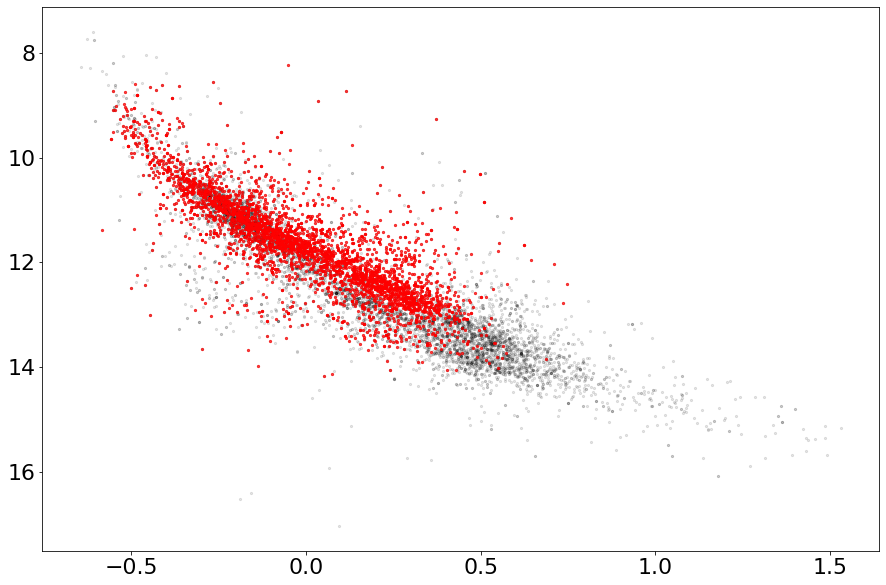

In [5]:
wdtable = Table.read('wdtable_sn.fits')

good = (
    (wdtable['subclass'] == 'WD')[:,0].data
)

print(len(wdtable[good]))
plt.scatter(wdtable['bp_rp'],wdtable['abs_g'],s = 5, alpha=0.1,color='k')
plt.scatter(wdtable[good]['bp_rp'],wdtable[good]['abs_g'],s = 5, alpha=0.7,color='r')
plt.gca().invert_yaxis()
wdtable = wdtable[good]

In [6]:
bgrid = np.linspace(np.min(wdtable['bp_rp']),np.max(wdtable['bp_rp']),50)
ggrid = np.linspace(np.min(wdtable['abs_g']),np.max(wdtable['abs_g']),50)
bint = bgrid[1]-bgrid[0]
gint = ggrid[1]-ggrid[0]

In [7]:
selections = [];
for i in tqdm(bgrid):
    for j in ggrid:
        square = (wdtable['bp_rp'] > i)*(wdtable['abs_g'] > j)*\
                (wdtable['bp_rp'] < i+bint)*(wdtable['abs_g'] < j+gint)
        if len(wdtable[square]) > 0:
            snmaxidx = np.argmax(wdtable[square]['S2N'])
            selections.append(wdtable[square][snmaxidx]['specnames'])

100%|██████████| 50/50 [01:12<00:00,  1.06it/s]


In [8]:
idxs = [];
for i in selections:
    idxs.append(np.argmax(wdtable['specnames'] == i))

In [9]:
goodtable = wdtable[idxs]
len(goodtable)

713

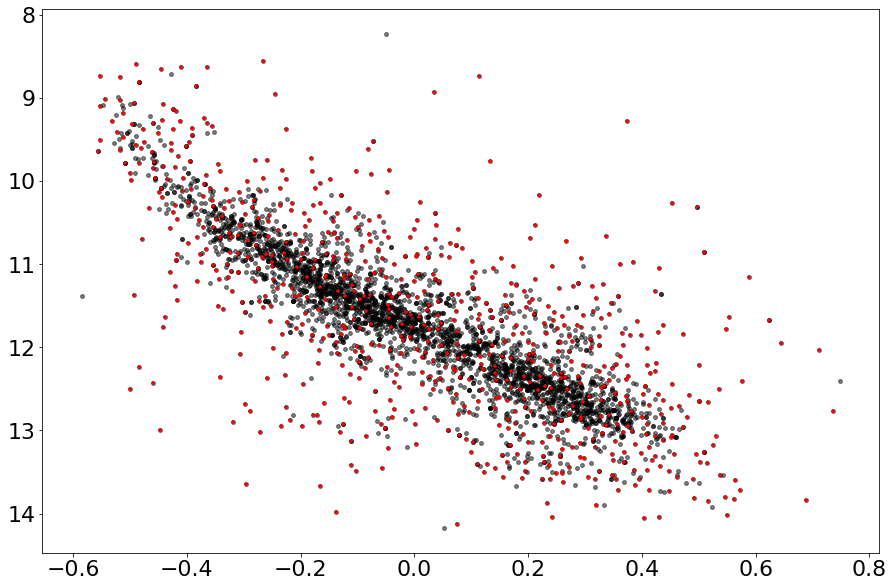

In [10]:
plt.figure(figsize=(15,10))
plt.scatter(wdtable['bp_rp'],wdtable['abs_g'],s=15,color='k',alpha=0.5)
plt.scatter(goodtable['bp_rp'],goodtable['abs_g'],s=15,color='r',marker='+')
plt.gca().invert_yaxis()

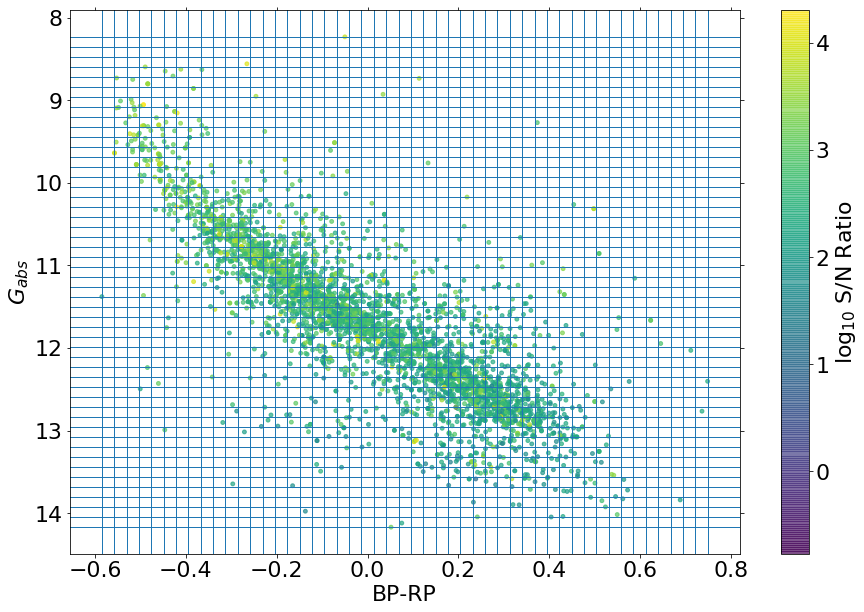

In [11]:
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.figure(figsize=(15,10))

for i in range(len(bgrid)):
    plt.axvline(bgrid[i],linewidth=1)
    plt.axhline(ggrid[i],linewidth=1)

plt.scatter(wdtable['bp_rp'],wdtable['abs_g'],s=15,alpha=0.7,c=wdtable['S2N'])
cbar = plt.colorbar()

cbar.ax.set_ylabel('$\log_{10}$ S/N Ratio')
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('$G_{abs}$')
plt.rcParams.update({'font.size': 22})


In [12]:
bigtable = wdtable
wdtable = goodtable
TeffHs = [];
loggHs = [];
specnames = []
spectra = [];

# def rvcorr(spectrum):
#     lamgrid = np.arange(4000,8000)
#     coremask = (lamgrid == 6565)+(lamgrid == 4863)+(lamgrid == 4342)+(lamgrid == 4103)
#     coremask = coremask.astype(int)
#     trans = np.argmax(np.correlate(1-spectrum,coremask,mode='full'))-4000
#     if trans > 5:
#         trans = 5;
#     elif trans < 5:
#         trans = -5;
#     else:
#         ;
#     shiftedspec = interpolation.shift(spectrum,-trans,cval=1)
#     return shiftedspec

searchparameter = list(wdtable['specnames'])
bprps = [];
gs = [];
## Enter search parameter, if needed:
inputPath = "../scratch/spec_old/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]

from scipy.signal import medfilt
from scipy.interpolate import interp1d

len(filenames)

for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    spectra.append(flux)
    TeffHs.append(wdtable[wdtable['specnames']==specname[:-5]]['TeffH'][0])
    loggHs.append(wdtable[wdtable['specnames']==specname[:-5]]['loggH'][0])
    bprps.append(wdtable[wdtable['specnames']==specname[:-5]]['bp_rp'][0])
    gs.append(wdtable[wdtable['specnames']==specname[:-5]]['abs_g'][0])
    specnames.append(specname)
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)
bprps = np.asarray(bprps)
gs = np.asarray(gs)

100%|██████████| 713/713 [02:57<00:00,  4.42it/s]


In [13]:
lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

In [14]:
normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10) + \
        (lamgrid > 5173 - 10)*(lamgrid < 5173 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    #contcorr = np.log(contcorr)
    where = np.isnan(contcorr)
    contcorr[where] = 0
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)

100%|██████████| 713/713 [00:01<00:00, 379.09it/s]


713

2.4817714575461522


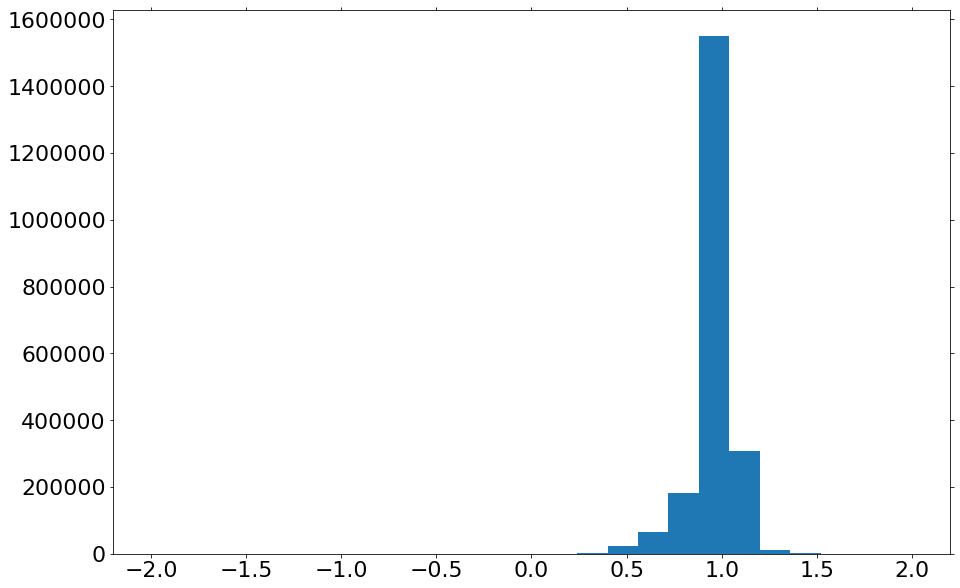

In [15]:
print(np.max(normspec))
plt.hist(np.ravel(normspec),bins=25,range = (-2,2));

In [16]:
where = (normspec > 2.5)+(normspec < -1)

In [17]:
normspec[where] = 1

2.4817714575461522


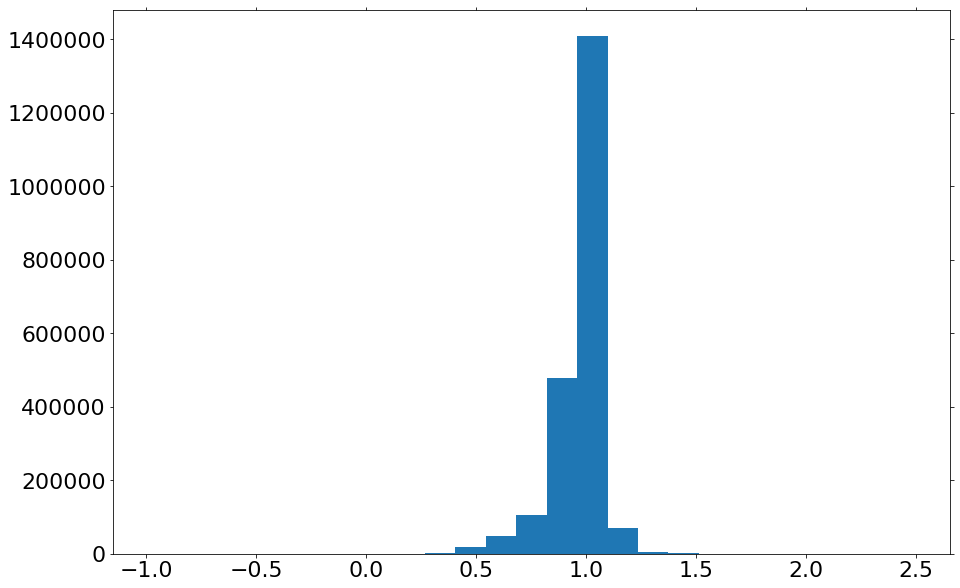

In [18]:
plt.hist(np.ravel(normspec),bins=25);
print(np.max(normspec))

# Train Generator

In [19]:
sc = StandardScaler()
msc = StandardScaler()

In [20]:
X = sc.fit_transform(np.stack((bprps,gs)).transpose())
t = msc.fit_transform(normspec)

In [21]:
#import keras
def generator():
    x = Input(shape=X[0].shape)
    y = Dense(25,activation='sigmoid')(x)
    y = Dropout(0.5)(y)
    y = Dense(25,activation='sigmoid')(y)
    y = Dropout(0.5)(y)
    out = Dense(t[0].shape[0],activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.001), loss = 'mse', \
                  metrics = ['mean_absolute_percentage_error'])
    return model
model = generator()
print(model.summary())
model.load_weights('ddriven_outliers.h5')

W0814 17:21:12.018728 47489557390656 deprecation_wrapper.py:119] From /home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 17:21:12.038941 47489557390656 deprecation_wrapper.py:119] From /home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 17:21:12.042636 47489557390656 deprecation_wrapper.py:119] From /home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 17:21:12.054390 47489557390656 deprecation_wrapper.py:119] From /home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is depre

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                75        
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3000)              78000     
Total params: 78,725
Trainable params: 78,725
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
epoch = 10000
batch = len(X)
history = [];
for i in tqdm(range(epoch)):
    h = model.fit(X,t,epochs=1,verbose=0,batch_size=batch)
    history.append(h.history['loss'][0])

100%|██████████| 10000/10000 [03:31<00:00, 47.25it/s]


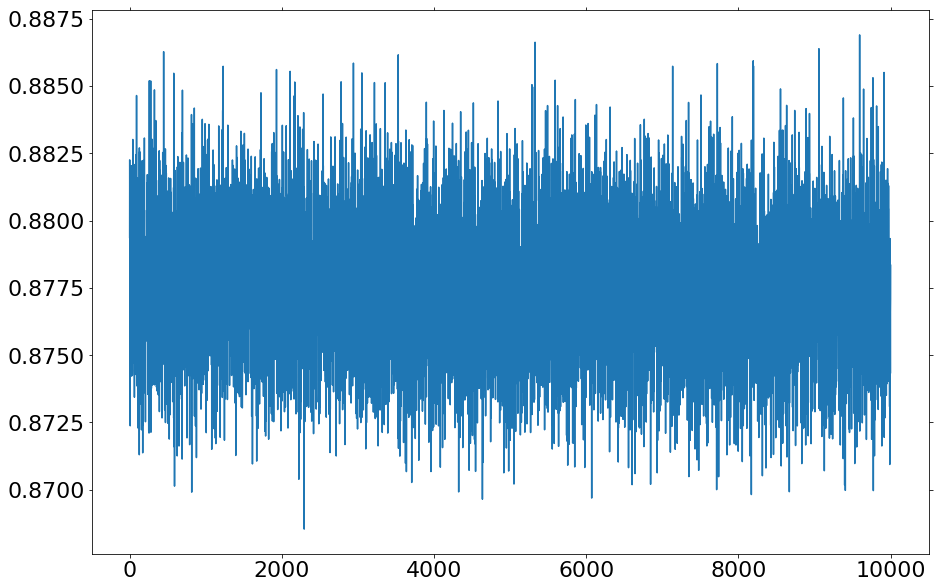

In [23]:
plt.plot((history))

### Evaluate BPRP Sensitivity

Text(0.5, 1.0, 'H-Beta Line')

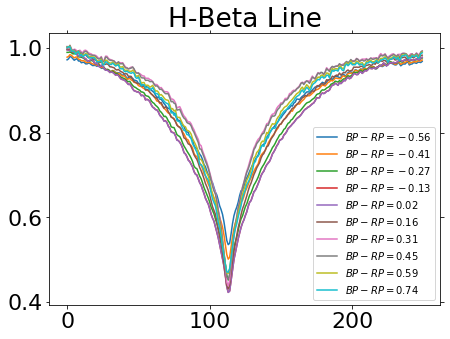

In [24]:
plt.figure(figsize=(7,5))
ts = np.linspace(min(bprps),max(bprps),10)
ls = np.linspace(np.mean(gs),np.mean(gs),10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$BP-RP = %.2f$'%ts[i])
plt.legend(fontsize=10)
plt.title('H-Beta Line')

### Evaluate G_abs Sensitivity

Text(0.5, 1.0, 'H-Beta Line')

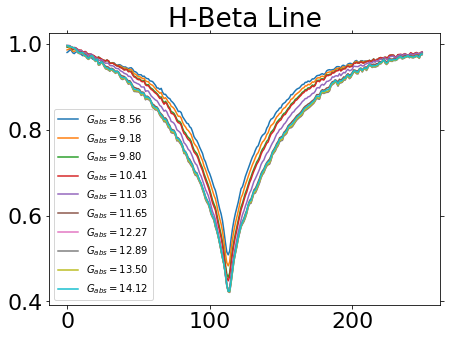

In [25]:
plt.figure(figsize=(7,5))
ts = np.linspace(np.mean(bprps),np.mean(bprps),10)
ls = np.linspace(min(gs),max(gs),10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$G_{abs} = %.2f$'%ls[i])

plt.legend(fontsize=10)
plt.title('H-Beta Line')

## Fitter

In [38]:
filename = ['887586156003183744_spec_0.fits']

In [39]:
inputPath = '../scratch/spec/spectra_batch_007/'
spectra = []
TeffHs = []
loggHs = []
specnames = []
for specname in tqdm(filename):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    spectra.append(flux)
    specnames.append(specname)
    f.close()
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)
bprps = np.asarray(bprps)
gs = np.asarray(gs)

lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    #contcorr = np.log(contcorr)
    where = np.isnan(contcorr)
    contcorr[where] = 0
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)

100%|██████████| 1/1 [00:00<00:00, 247.99it/s]


1

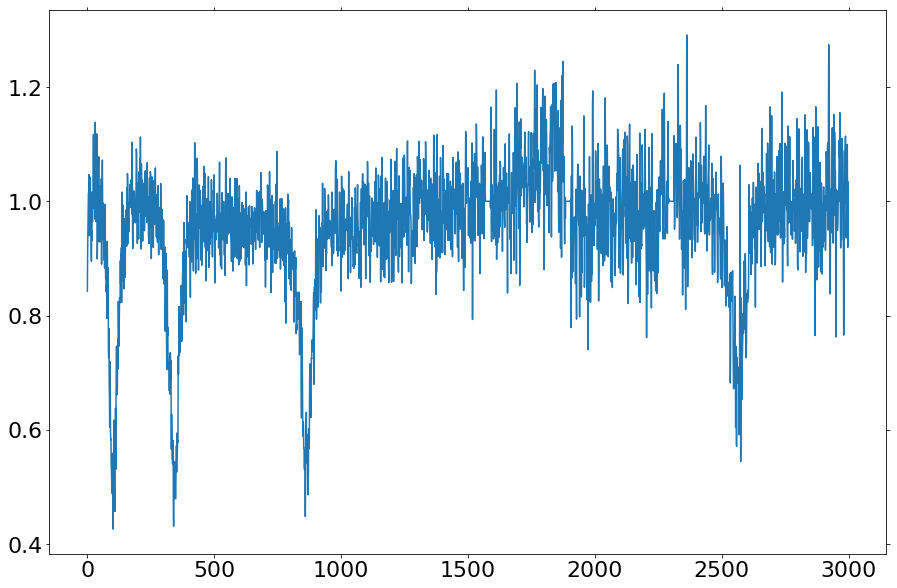

In [48]:
plt.plot(normspec[0])

In [49]:
def spectrum_sampler(wl,bprp,absg,trans):
    label = sc.transform(np.asarray(np.stack((bprp,absg)).reshape(1,-1)))
    synth = interpolation.shift(msc.inverse_transform(model.predict(label)[0]),trans,cval=np.nan)
    return (synth).astype('float32')
import scipy
lamgrid = np.arange(4000,7000)
fitter = lmfit.Model(spectrum_sampler)
params = fitter.make_params(bprp = 0.,absg=10.,trans=0.)
lam = lamgrid
lines = lines = ((lam > hbeta-200) & (lam < hbeta + 200)) | ((lam > halpha-200) & (lam < halpha + 200))\
        | ((lam > hgamma-320) & (lam < hgamma + 100))


modelscaling = 1
from astropy.convolution import Gaussian1DKernel
from scipy.signal import convolve as scipy_convolve

def chisquare(residual):
    return sum(residual**2)

def binary_sampler(wl,bprp1,absg1,trans1,bprp2,absg2,trans2):
    synth = (spectrum_sampler(wl,bprp1,absg1,trans1) + spectrum_sampler(wl,bprp2,absg2,trans2))/2
    synth = scipy.ndimage.filters.gaussian_filter1d(synth,5)
    return synth[lines]

In [50]:
max(bprps)

0.73600197

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting with Powell...


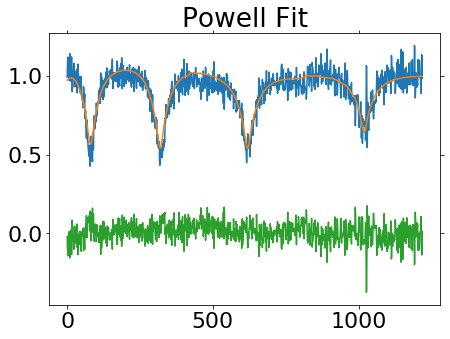

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 248
    # data points      = 1220
    # variables        = 6
    chi-square         = 4.45818993
    reduced chi-square = 0.00367231
    Akaike info crit   = -6834.47323
    Bayesian info crit = -6803.83359
##  Warning: uncertainties could not be estimated:
    absg2:   at initial value
[[Variables]]
    bprp1:  -0.09836487 +/-        nan (nan%) (init = 0)
    absg1:   10.0014309 +/-        nan (nan%) (init = 10)
    trans1: -1.12252734 +/- 1.34574556 (119.89%) (init = 0)
    bprp2:   1.2893e-04 +/-        nan (nan%) (init = 0)
    absg2:   9.99999852 +/-        nan (nan%) (init = 10)
    trans2: -0.50431015 +/- 1.26307009 (250.46%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(trans1, trans2) = -0.846

 Starting Bayesian Sampling................
...Done.


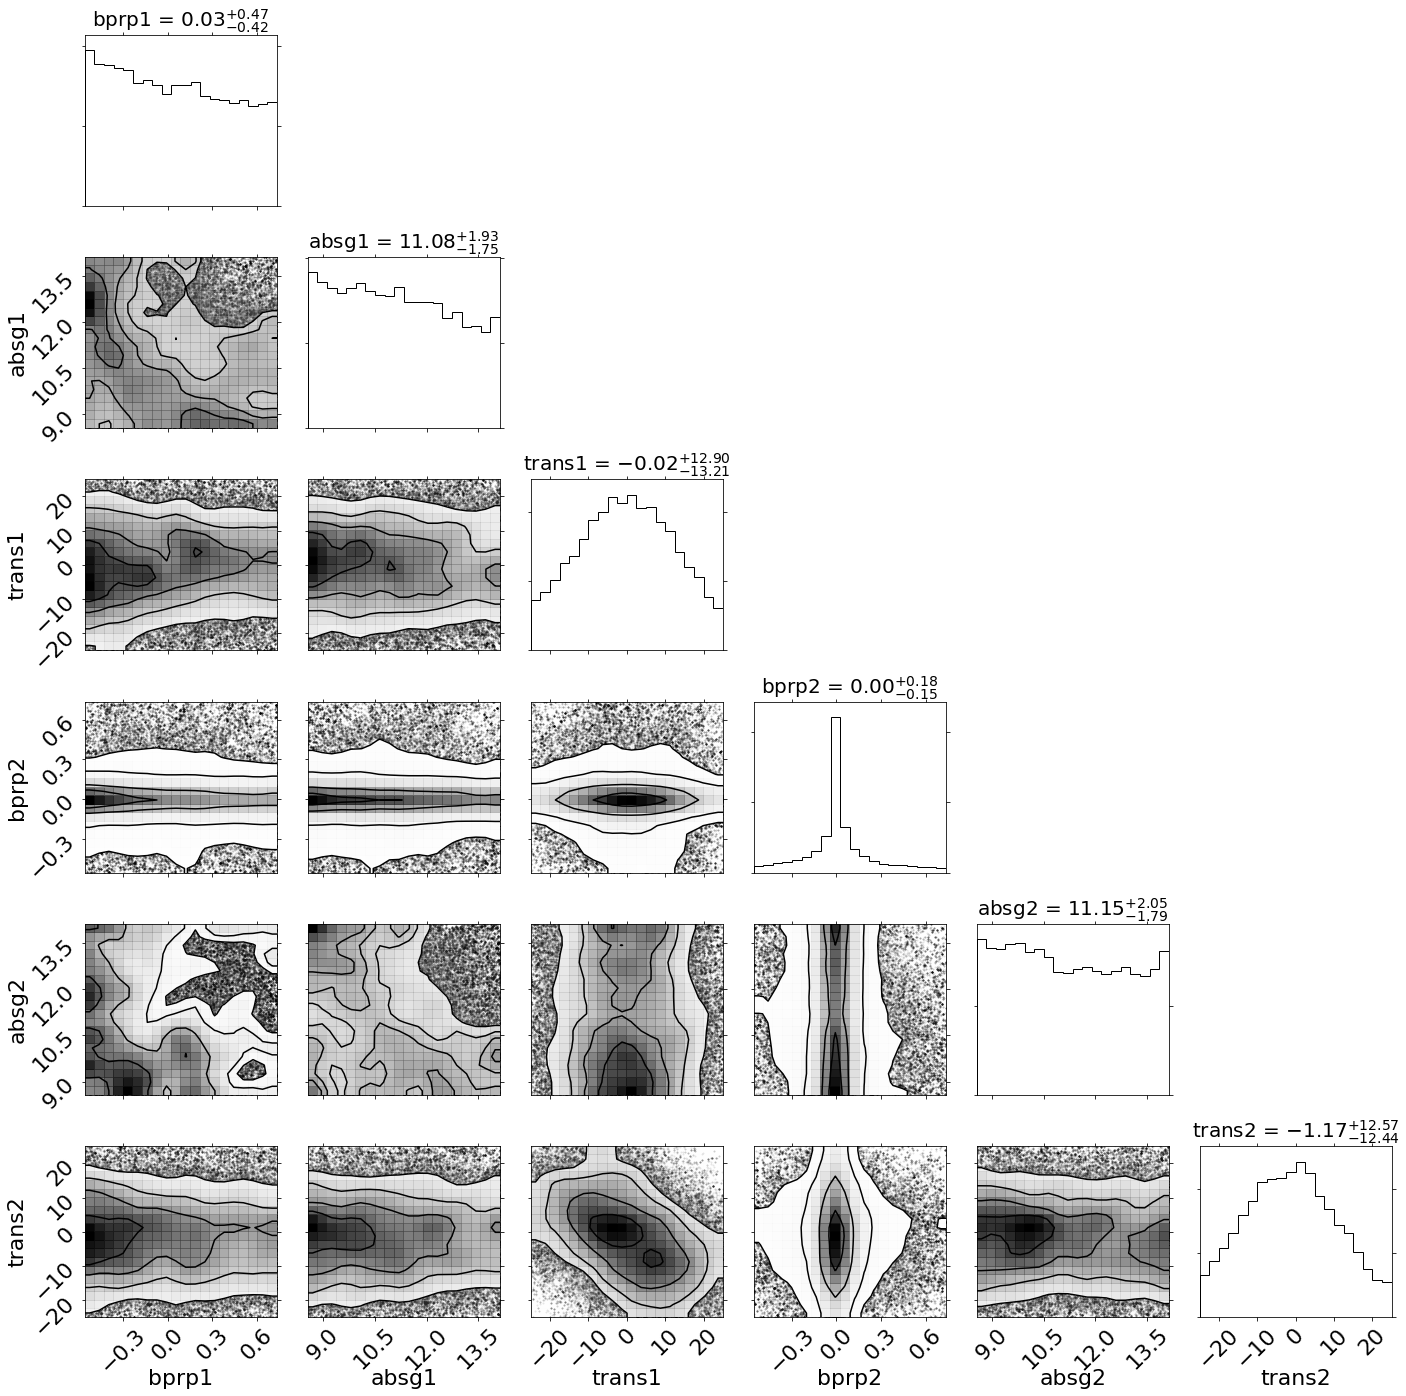

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 275000
    # data points      = 1220
    # variables        = 6
    chi-square         = 5.18391113
    reduced chi-square = 0.00427011
    Akaike info crit   = -6650.47651
    Bayesian info crit = -6619.83688
[[Variables]]
    bprp1:   0.02685270 +/- 0.44422580 (1654.31%) (init = -0.09836487)
    absg1:   11.0814543 +/- 1.85232435 (16.72%) (init = 10.00143)
    trans1: -0.01839907 +/- 13.1295935 (71360.11%) (init = -1.122527)
    bprp2:   1.8351e-04 +/- 0.17057094 (92948.84%) (init = 0.0001289315)
    absg2:   11.1521846 +/- 1.92631679 (17.27%) (init = 9.999999)
    trans2: -1.16592229 +/- 12.5596782 (1077.23%) (init = -0.5043102)
[[Correlations]] (unreported correlations are < 0.100)
    C(trans1, trans2) = -0.357
    C(bprp1, absg1)   = -0.123
    C(absg1, absg2)   = -0.122


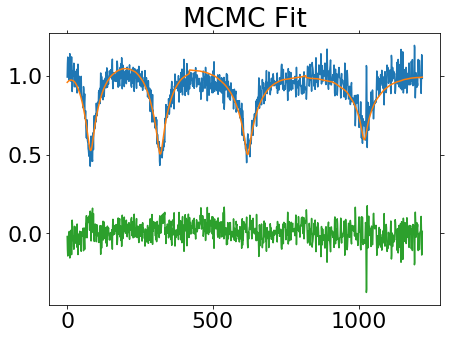

100%|██████████| 1/1 [04:55<00:00, 295.31s/it]


In [51]:
lamgrid = np.arange(4000,7000)
fitter = lmfit.Model(binary_sampler)
params = fitter.make_params(bprp1 = 0.,absg1=10.,trans1=0.,bprp2 = 0.,absg2=10.,trans2=0.)
lam = lamgrid
lines = lines = ((lam > hbeta-200) & (lam < hbeta + 200)) | ((lam > halpha-200) & (lam < halpha + 200))\
        | ((lam > hgamma-320) & (lam < hgamma + 100))

params['bprp1'].set(min=np.min(bprps),max=np.max(bprps))
params['absg1'].set(min=np.min(gs),max=np.max(gs))
params['bprp2'].set(min=np.min(bprps),max=np.max(bprps))
params['absg2'].set(min=np.min(gs),max=np.max(gs))
params['trans1'].set(min=-25,max=25)
params['trans2'].set(min=-25,max=25)

bayesparams = fitter.make_params(bprp1 = 0.,absg1=10.,trans1=0.,bprp2 = 0.,absg2=10.,trans2=0.)
bayesparams['bprp1'].set(min=np.min(bprps),max=np.max(bprps))
bayesparams['absg1'].set(min=np.min(gs),max=np.max(gs))
bayesparams['bprp2'].set(min=np.min(bprps),max=np.max(bprps))
bayesparams['absg2'].set(min=np.min(gs),max=np.max(gs))
bayesparams['trans1'].set(min=-25,max=25)
bayesparams['trans2'].set(min=-25,max=25)

fitoutput = np.zeros((len(normspec),9))
bayesoutput = np.zeros((len(normspec),9))
for i in tqdm(range(len(normspec))):
    spec = normspec[i][lines]
    fitoutput[i,0] = int(specnames[i][:-12])
    bayesoutput[i,0] = int(specnames[i][:-12])
    print('Fitting with Powell...')
    result = fitter.fit(spec*modelscaling,params,wl=lamgrid[lines],method="powell",nan_policy='omit',calc_covar=True,
                       fit_kws={'reduce_fcn':chisquare})
    
    fitoutput[i,1] = result.params['bprp1'].value
    fitoutput[i,2] = result.params['bprp1'].stderr
    fitoutput[i,3] = result.params['absg1'].value
    fitoutput[i,4] = result.params['absg1'].stderr
    fitoutput[i,5] = result.params['bprp2'].value
    fitoutput[i,6] = result.params['bprp2'].stderr
    fitoutput[i,7] = result.params['absg2'].value
    fitoutput[i,8] = result.params['absg2'].stderr
    
    plt.figure(figsize=(7,5))
    plt.plot(spec*modelscaling)
    plt.plot(binary_sampler(None,result.params['bprp1'],result.params['absg1'],result.params['trans1'],\
                           result.params['bprp2'],result.params['absg2'],result.params['trans2']))
    plt.plot(result.residual)
    plt.title('Powell Fit')
    plt.show()
    print(lmfit.fit_report(result))
    
    # BAYESIAN FITTING ##
    
    bayesparams['bprp1'].set(value = result.params['bprp1'].value)
    bayesparams['absg1'].set(value = result.params['absg1'].value)
    bayesparams['bprp2'].set(value = result.params['bprp2'].value)
    bayesparams['absg2'].set(value = result.params['absg2'].value)
    bayesparams['trans1'].set(value = result.params['trans1'].value)
    bayesparams['trans2'].set(value = result.params['trans2'].value)
    
    print('\n Starting Bayesian Sampling................')
    bayesresult = fitter.fit(spec*modelscaling,bayesparams,wl=lamgrid[lines],method="emcee",nan_policy='omit',\
                             calc_covar=True, fit_kws={'nwalkers':500,'steps':550,'burn':250,'reduce_fcn':chisquare})
    print('...Done.')
    fig,axs = plt.subplots(6,6,figsize=(20,20))
    f = corner.corner(bayesresult.flatchain[['bprp1','absg1','trans1','bprp2','absg2','trans2']],\
                      smooth=1,show_titles=True,fig=fig,title_kwargs={'fontsize':20})
    plt.tight_layout()
    plt.show()
    print(lmfit.fit_report(bayesresult))
    plt.figure(figsize=(7,5))
    plt.plot(spec*modelscaling)
    plt.plot(binary_sampler(None,bayesresult.params['bprp1'],bayesresult.params['absg1'],bayesresult.params['trans1'],\
                           bayesresult.params['bprp2'],bayesresult.params['absg2'],bayesresult.params['trans2']))    
    plt.plot(result.residual)
    plt.title('MCMC Fit')
    plt.show()
    bayesoutput[i,1] = bayesresult.params['bprp1'].value
    bayesoutput[i,2] = bayesresult.params['bprp1'].stderr
    bayesoutput[i,3] = bayesresult.params['absg1'].value
    bayesoutput[i,4] = bayesresult.params['absg1'].stderr
    bayesoutput[i,5] = bayesresult.params['bprp2'].value
    bayesoutput[i,6] = bayesresult.params['bprp2'].stderr
    bayesoutput[i,7] = bayesresult.params['absg2'].value
    bayesoutput[i,8] = bayesresult.params['absg2'].stderr

### Evaluate Residuals of Random Control Spectra

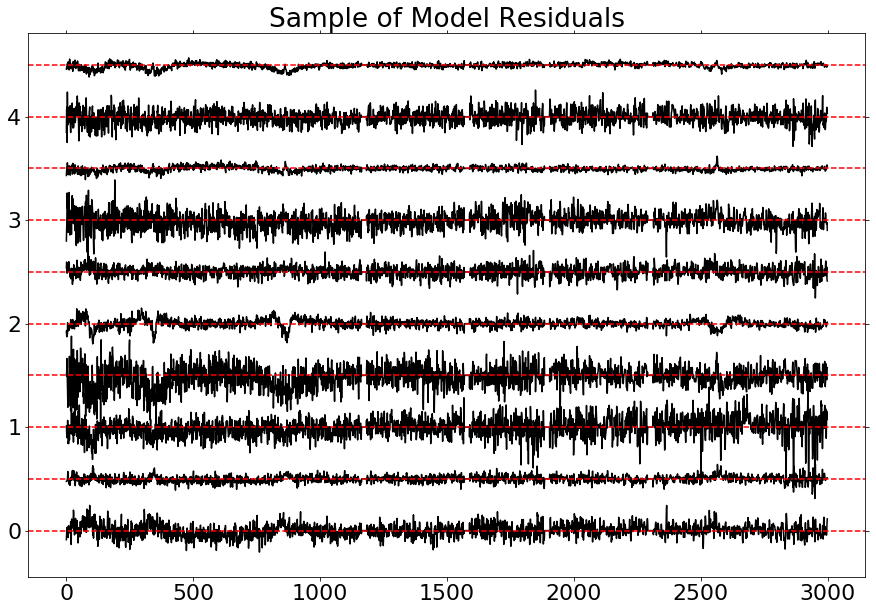

In [104]:
resids = msc.inverse_transform(model.predict(X))- msc.inverse_transform(t) 
plt.figure(figsize=(15,10))
ct=0
for i in np.random.randint(0,len(resids),10):
    plt.plot(resids[i] + 0.5*ct,'k')
    plt.axhline(0.5*ct,color='r',linestyle='--')
    ct += 1
    plt.title('Sample of Model Residuals')

In [207]:
preds = msc.inverse_transform(model.predict(X))
reals = msc.inverse_transform(t)
labels = sc.inverse_transform(X)

Text(0.5, 1.0, 'BP-RP = ')

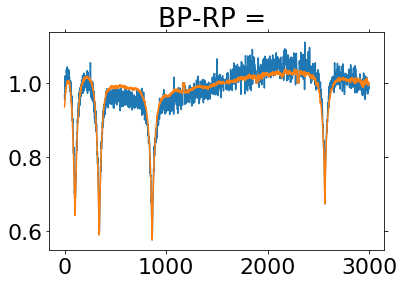

In [208]:
i = 35

label = labels[i]
plt.plot(reals[i])
plt.plot(preds[i])
plt.title('BP-RP = ')

## Autocorr Method

In [260]:
resids = msc.inverse_transform(model.predict(X)) - msc.inverse_transform(t)

In [261]:
autos = [];
corrtimes = [];
for i in range(len(resids)):
    autocorr = np.correlate(resids[i],resids[i],mode='full')
    autocorr = autocorr/max(autocorr)
    corrtime = sum(autocorr)
    autos.append(autocorr)
    corrtimes.append(corrtime)

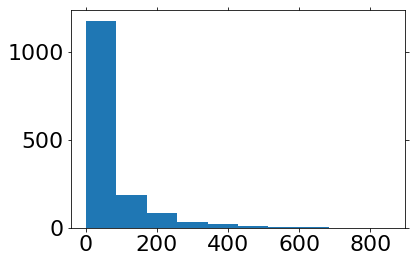

In [262]:
plt.hist(corrtimes,bins=10);

In [270]:
outliers = np.asarray(corrtimes) > 600
outspec = normspec[outliers]
outpred = msc.inverse_transform(model.predict(X)[outliers])
outlabel = sc.inverse_transform(X[outliers])
outresids = resids[outliers]
outautos = np.asarray(autos)[outliers]
len(X[outliers])

4

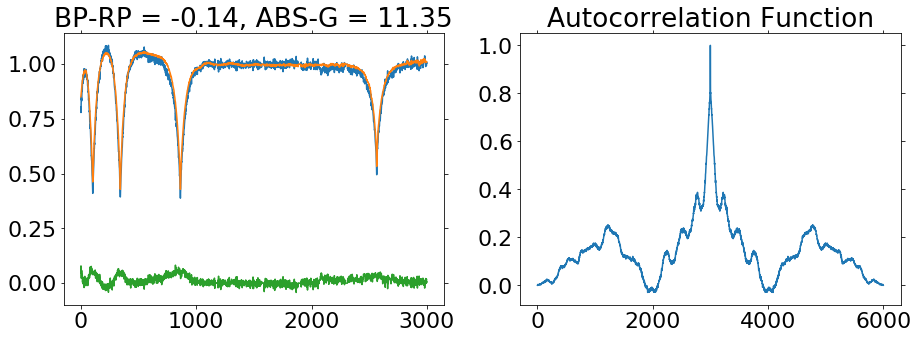

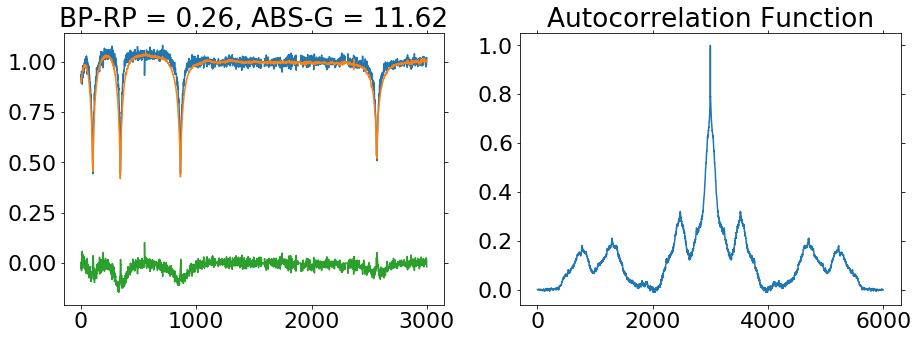

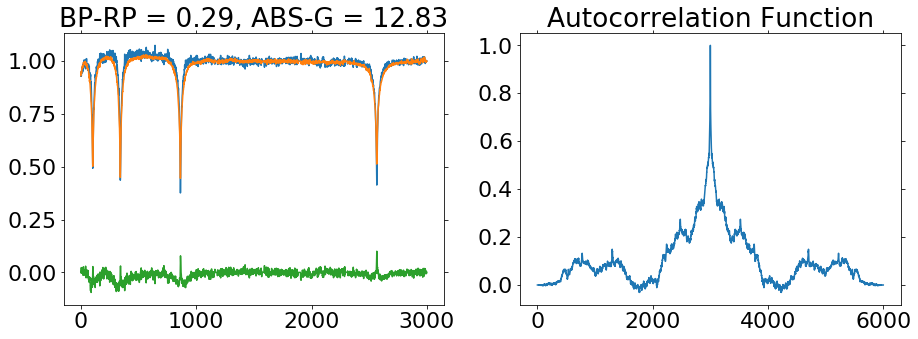

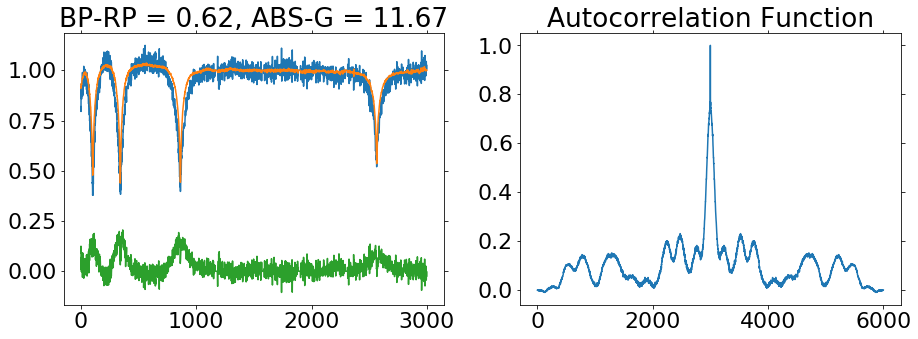

In [271]:
for i in range(sum(outliers)):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(outspec[i],label='Data')
    plt.title('BP-RP = %.2f, ABS-G = %0.2f'%(outlabel[i][0],outlabel[i][1]))
    plt.plot(outpred[i],label='Prediction')
    plt.plot(outresids[i])
    plt.subplot(122)
    plt.title('Autocorrelation Function')
    plt.plot(outautos[i])
    plt.show()

# Shapiro Test

In [67]:
shaps = [];
for i in range(len(resids)):
    shaps.append(stats.shapiro(resids[i])[0])

In [68]:
shaps = np.asarray(shaps)

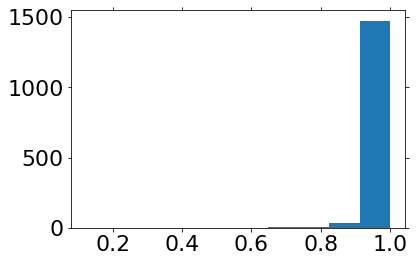

In [69]:
plt.hist(shaps);

In [72]:
outliers = shaps < 0.85

outspec = normspec[outliers]
outpred = msc.inverse_transform(model.predict(X)[outliers])
outlabel = sc.inverse_transform(X[outliers])
outnames = np.asarray(specnames)[outliers]

1434748982169485568_spec_1.fits


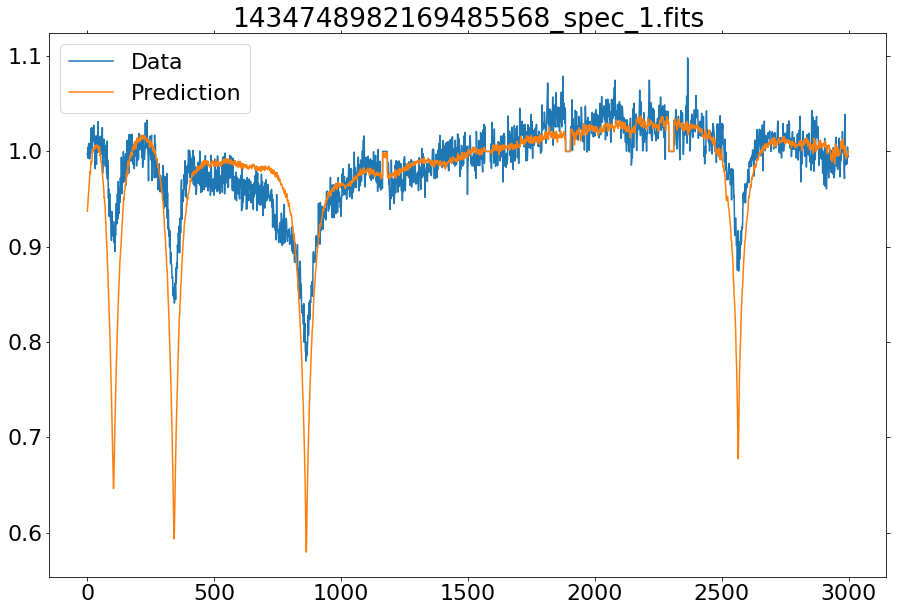

3302538209462061696_spec_0.fits


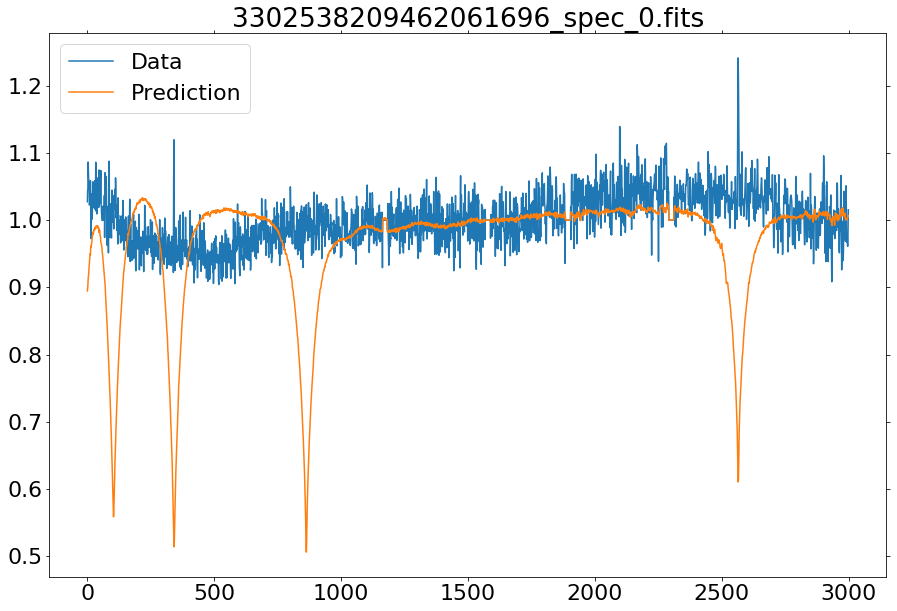

4417843183603168640_spec_2.fits


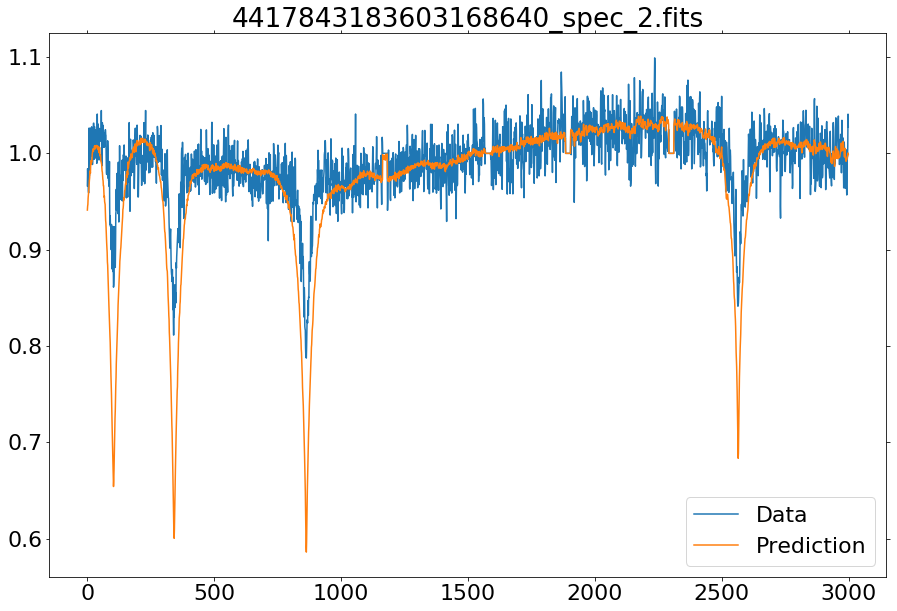

1195463537927048320_spec_0.fits


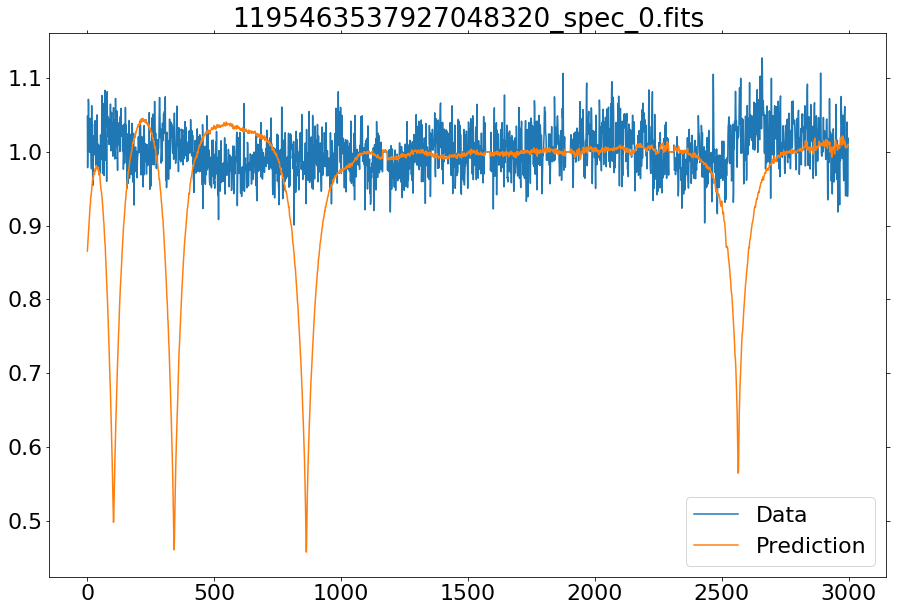

700346923589710080_spec_0.fits


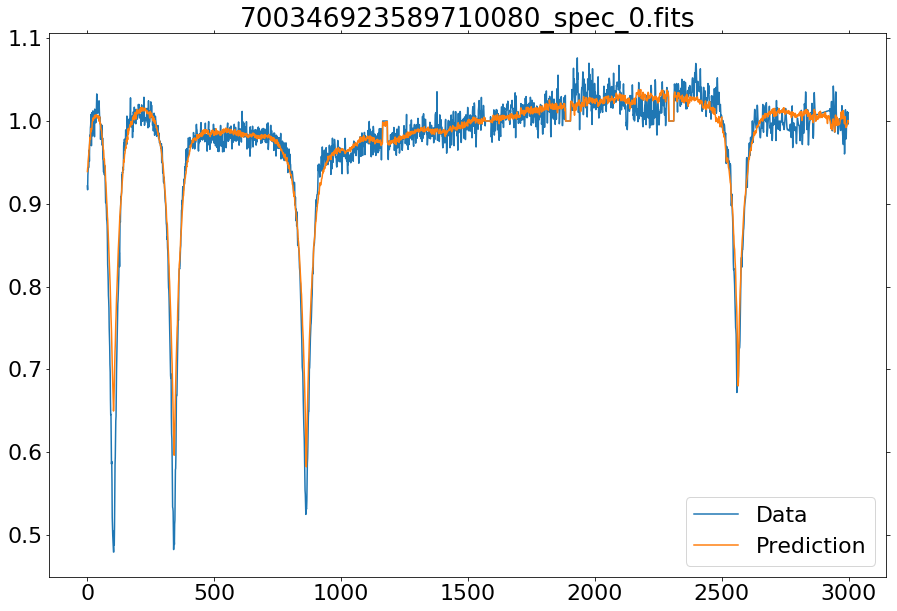

4487216358658978560_spec_0.fits


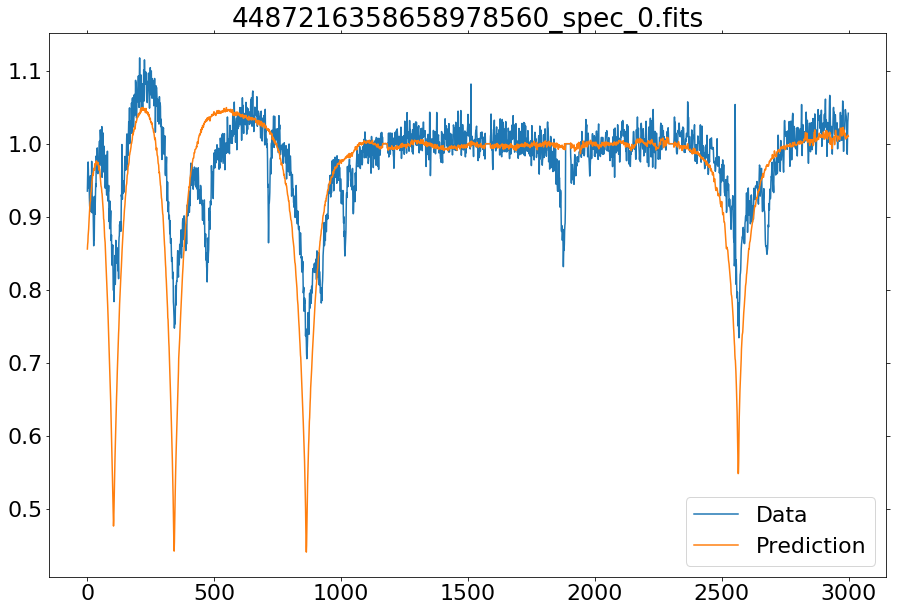

3302526729012505472_spec_0.fits


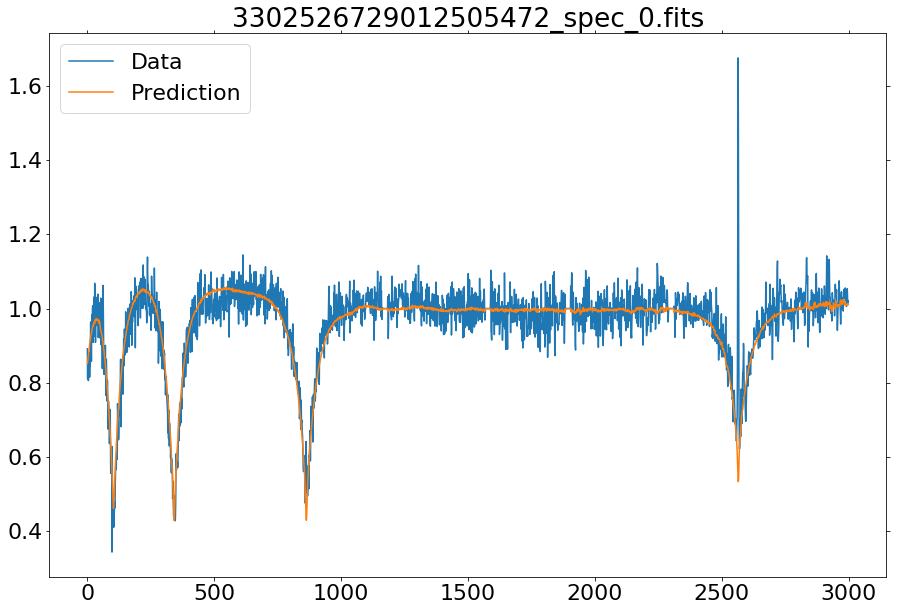

1243679832928795136_spec_0.fits


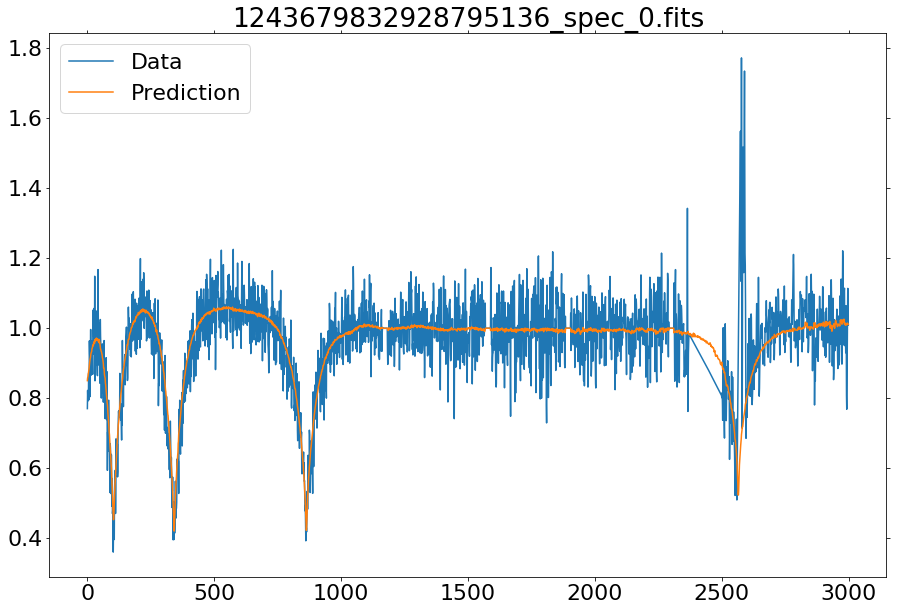

2542961560852591744_spec_0.fits


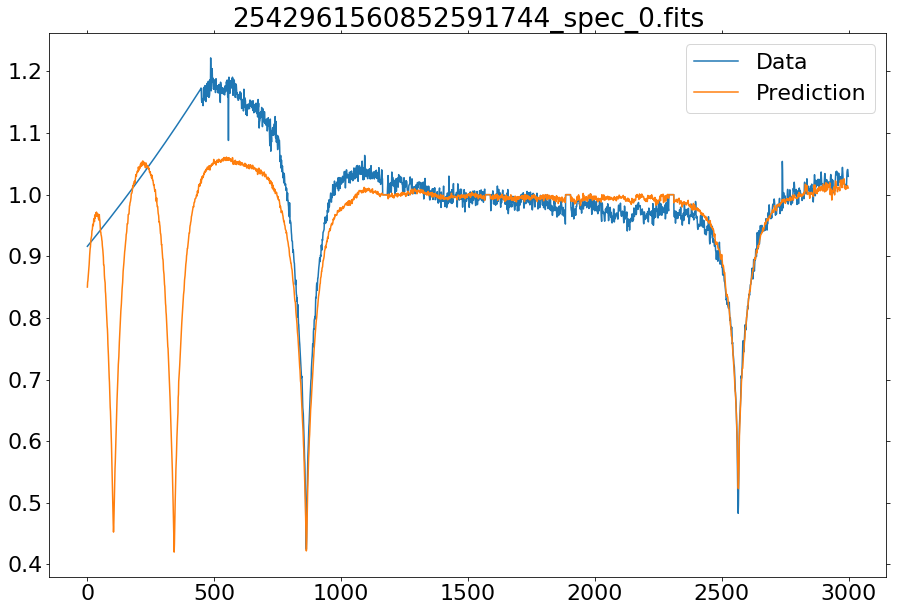

3806602267172416000_spec_0.fits


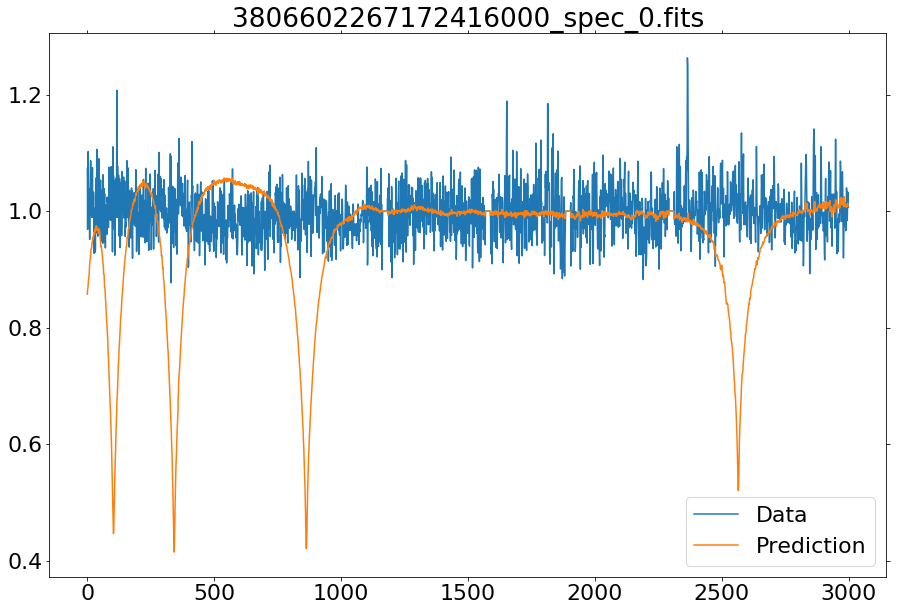

4463904719284925440_spec_0.fits


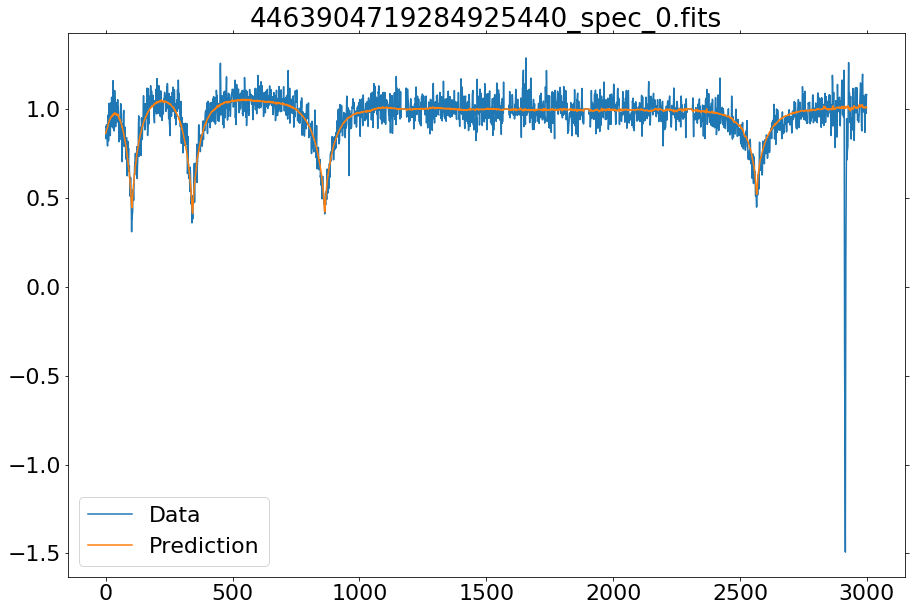

3681955719172822400_spec_0.fits


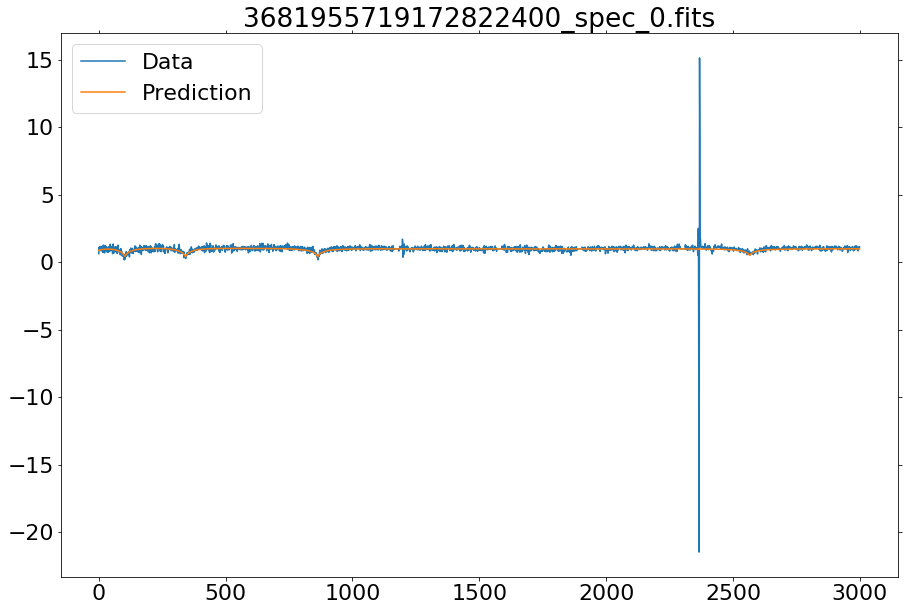

721244821406496640_spec_0.fits


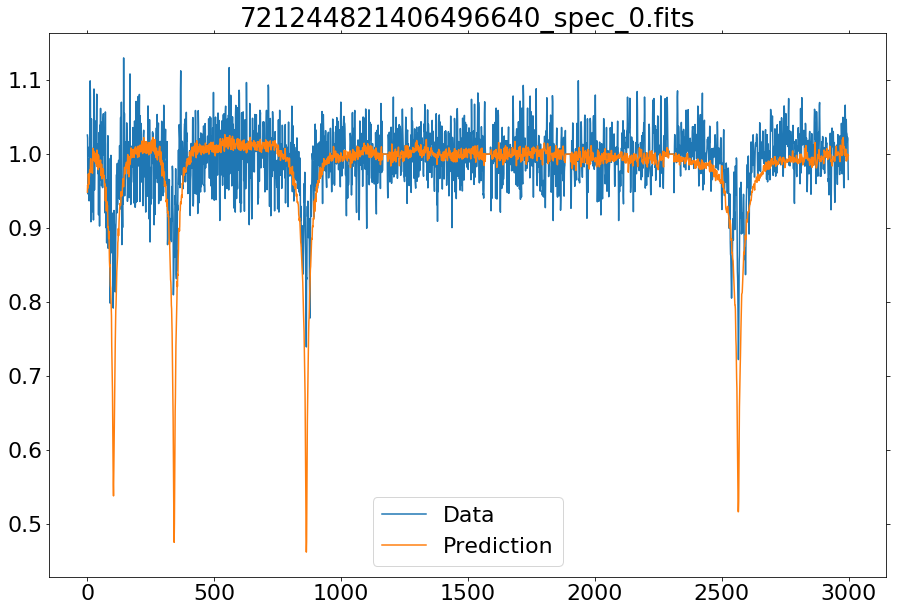

1523116177642231808_spec_0.fits


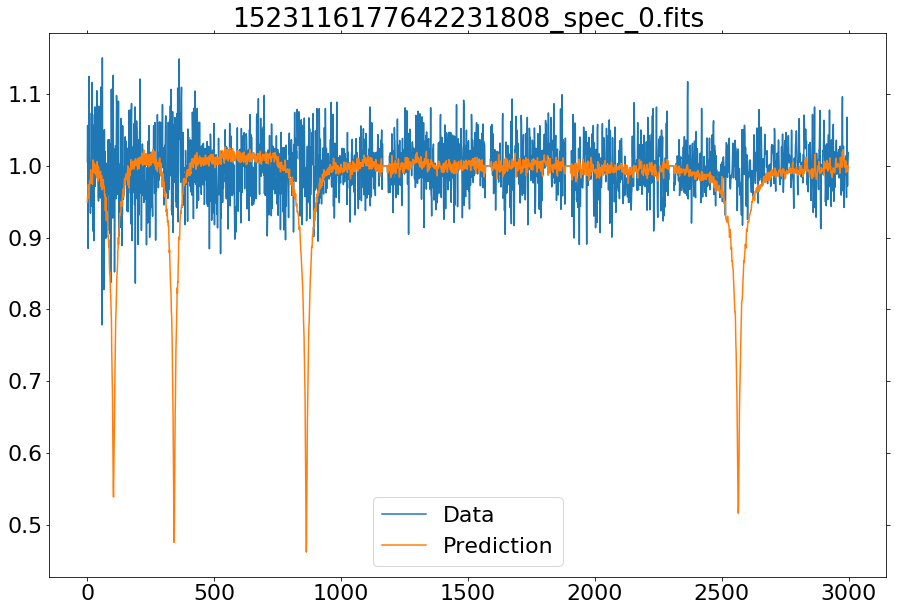

In [74]:
for i in range(sum(outliers)):
    plt.figure(figsize=(15,10))
    plt.plot(outspec[i],label='Data')
    #plt.title('BP-RP = %.2f, ABS-G = %0.2f'%(outlabel[i][0],outlabel[i][1]))
    plt.title(outnames[i])
    plt.plot(outpred[i],label='Prediction')
    plt.legend()
    print(outnames[i])
    plt.show()

# PRF

In [22]:
X_syn = msc.inverse_transform(model.predict(X)) 
X = msc.inverse_transform(t)

In [28]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,RandomForestClassifier
import numpy
obj_ids = (np.linspace(0,len(X),len(X)+1)).astype(int)

In [29]:
def merge_work_and_synthetic_samples(X, X_syn):
    """
    The function merges the data into one sample, giving the label "1" to the real data and label "2" to the synthetic data
    """
    # build the labels vector
    Y = numpy.ones(len(X))
    Y_syn = numpy.ones(len(X_syn)) * 2

    Y_total = numpy.concatenate((Y, Y_syn))
    X_total = numpy.concatenate((X, X_syn))
    return X_total, Y_total

X_total, Y_total = merge_work_and_synthetic_samples(X, X_syn)

In [54]:
N_TRAIN = 500 # number of trees in the forest
rand_f = RandomForestClassifier(n_estimators=N_TRAIN)
rand_f.fit(X_total, Y_total)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
def build_similarity_matrix(rand_f, X):
    """
    The function builds the similarity matrix based on the feature matrix X for the results Y
    based on the random forest we've trained
    the matrix is normalised so that the biggest similarity is 1 and the lowest is 0

    This function counts only leaves in which the object is classified as a "real" object 
    it is also implemented to optimize running time, asumming one has enough running memory
    """
    # apply to get the leaf indices
    apply_mat = rand_f.apply(X)
    # find the predictions of the sample
    is_good_matrix = numpy.zeros(apply_mat.shape)
    for i, est in enumerate(rand_f.estimators_):
        d = est.predict_proba(X)[:, 0] == 1
        is_good_matrix[:, i] = d
    # mark leaves that make the wrong prediction as -1, in order to remove them from the distance measurement
    apply_mat[is_good_matrix == False] = -1 
    # now calculate the similarity matrix
    sim_mat = numpy.sum((apply_mat[:, None] == apply_mat[None, :]) & (apply_mat[:, None] != -1) & (apply_mat[None, :] != -1), axis=2) / numpy.asfarray(numpy.sum([apply_mat != -1], axis=2), dtype='float')
    return sim_mat

sim_mat = build_similarity_matrix(rand_f, X)
dis_mat = 1 - sim_mat

Text(0.5, 0, 'weirdness score')

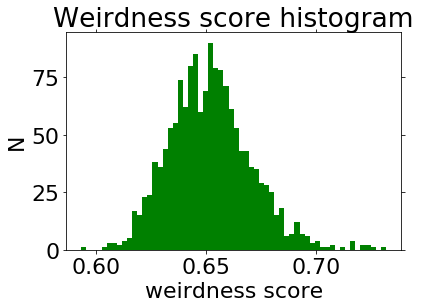

In [56]:
sum_vec = numpy.sum(dis_mat, axis=1)
sum_vec /= float(len(sum_vec))

plt.rcParams['figure.figsize'] = 6, 4
plt.title("Weirdness score histogram")
tmp = plt.hist(sum_vec, bins=60, color="g")
plt.ylabel("N")
plt.xlabel("weirdness score")

In [59]:
N_outliers = 10
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]

# plt.rcParams['figure.figsize'] = 10, 10
# plt.title("Data and outliers")
# plt.plot(TeffHs, loggHs, "ok", label="input daya", markersize=4)
# plt.plot(TeffHs[obj_ids_outliers], loggHs[obj_ids_outliers], "om", label="outliers", markersize=4)
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")	
# plt.legend(loc="best")

In [60]:
candidates = list(wdtable['specnames'][obj_ids_outliers])
candidates = [i+'.fits' for i in candidates]

100%|██████████| 10/10 [00:00<00:00, 15.01it/s]


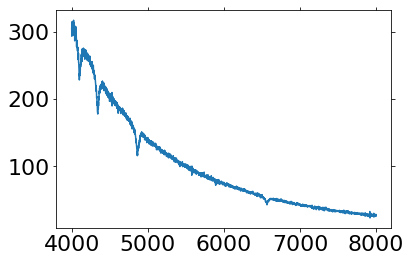

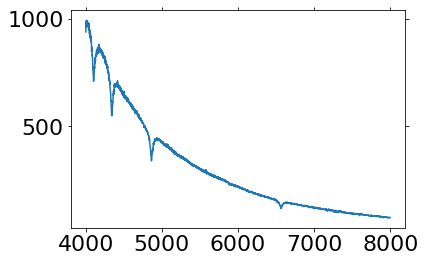

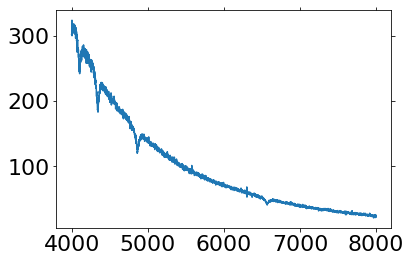

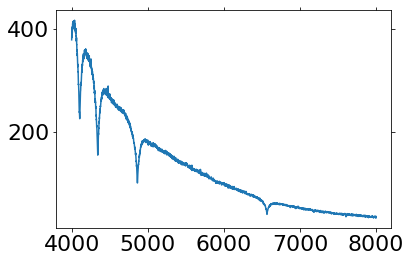

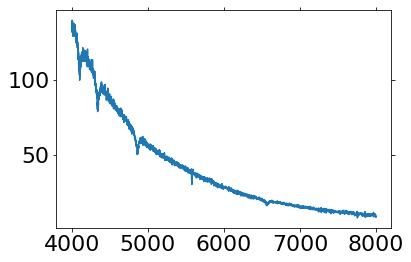

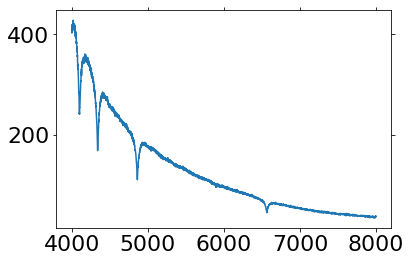

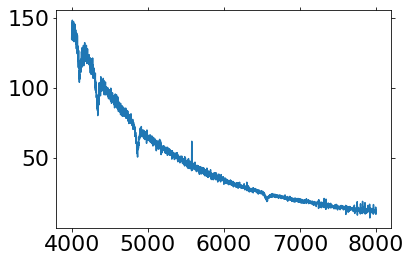

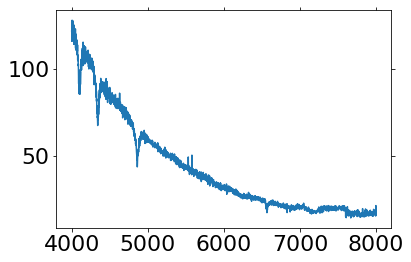

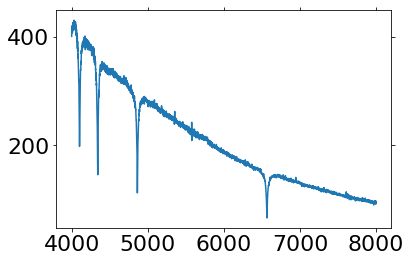

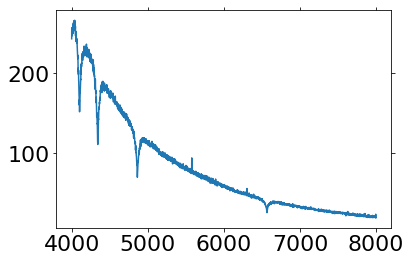

In [61]:
for specname in tqdm(candidates):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    plt.figure()
    plt.plot(lamgrid,flux)